<a href="https://colab.research.google.com/github/canmizrakli/TDSP.Net/blob/main/TDSP_YOLO_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO-based Task-driven Visual Saliency Prediction



This notebook demonstrates a complete workflow for building a YOLO-based architecture for task-based visual saliency prediction.

**Dataset Structure**  
Your dataset (stored on Google Drive at `/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768`) should be organized as follows:



**Task Definitions**  
- **task1** → free view  
- **task2** → count people  
- **task3** → detect the emotion  
- **task4** → identify the action

The notebook includes:  
- Paired data augmentation  
- A YOLO-based backbone (pre-trained)  
- A TaskEncoder using Sentence-BERT for rich task embeddings  
- A saliency-specific loss function (KL Divergence + (1 - Correlation Coefficient))

## Preprocessing

In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 2. Install Dependencies
!pip install --upgrade torch torchvision einops
!pip install ultralytics

### Data Augmentation & Paired Transforms

In [3]:
import random
import torchvision.transforms.functional as TF  # Use TF to avoid conflicts with torch.nn.functional

# Paired random horizontal flip
class PairedRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, sal):
        if random.random() < self.p:
            img = TF.hflip(img)
            sal = TF.hflip(sal)
        return img, sal

# Paired random rotation
class PairedRandomRotation:
    def __init__(self, degrees=10):
        self.degrees = degrees

    def __call__(self, img, sal):
        angle = random.uniform(-self.degrees, self.degrees)
        img = TF.rotate(img, angle)
        sal = TF.rotate(sal, angle)
        return img, sal

## Dataset Definition

In [4]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

# Define task mapping from folder names to descriptive labels.
task_mapping = {
    "task1": "Estimate the number of people present in the image (approximate count is acceptable).",
    "task2": "Identify and describe the emotional tone of the image (e.g., happy, sad, angry, etc.).",
    "task3": "Describe the context or activity in the image (what is happening or the occasion).",
    "task4": "Free viewing (no specific task)."
}

class TaskSaliencyDataset(Dataset):
    def __init__(self, data_root, task_mapping, transform=None, saliency_transform=None, paired_transforms=None):
        """
        data_root: Root path of the dataset.
        task_mapping: Dictionary mapping task folder names (e.g., "task1") to task descriptions.
        transform: Transforms for stimuli images (e.g., resizing, ToTensor).
        saliency_transform: Transforms for saliency maps.
        paired_transforms: List of callables that apply the same random transform to both stimuli and saliency.
        """
        self.data_root = data_root
        self.task_mapping = task_mapping
        self.transform = transform
        self.saliency_transform = saliency_transform
        self.paired_transforms = paired_transforms

        self.tasks = list(task_mapping.keys())
        self.samples = []

        # Iterate over each task folder and gather samples
        for task in self.tasks:
            task_folder = os.path.join(data_root, task)
            fdm_folder = os.path.join(task_folder, "fdm")
            fdm_files = glob.glob(os.path.join(fdm_folder, "*.png"))
            for fdm_file in fdm_files:
                filename = os.path.basename(fdm_file)
                base = os.path.splitext(filename)[0]
                # Look for corresponding stimuli image (.jpg or .png)
                stimuli_path_jpg = os.path.join(data_root, "stimuli", base + ".jpg")
                stimuli_path_png = os.path.join(data_root, "stimuli", base + ".png")
                if os.path.exists(stimuli_path_jpg):
                    stimuli_path = stimuli_path_jpg
                elif os.path.exists(stimuli_path_png):
                    stimuli_path = stimuli_path_png
                else:
                    continue
                self.samples.append((stimuli_path, fdm_file, task))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        stimuli_path, fdm_path, task = self.samples[idx]
        stimuli_img = Image.open(stimuli_path).convert("RGB")
        fdm_img = Image.open(fdm_path).convert("L")

        if self.transform:
            stimuli_img = self.transform(stimuli_img)
        if self.saliency_transform:
            fdm_img = self.saliency_transform(fdm_img)
        else:
            fdm_img = T.ToTensor()(fdm_img)

        # Apply paired transforms if defined
        if self.paired_transforms is not None:
            for t in self.paired_transforms:
                stimuli_img, fdm_img = t(stimuli_img, fdm_img)

        task_description = self.task_mapping[task]

        return {
            "stimuli": stimuli_img,
            "fdm": fdm_img,
            "task": task,
            "task_description": task_description
        }

# Define transforms
input_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
saliency_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
paired_transforms = [
    PairedRandomHorizontalFlip(p=0.5),
    PairedRandomRotation(degrees=10)
]

# Path to your dataset (adjust the path if needed)
DATA_PATH = "/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768"

dataset = TaskSaliencyDataset(
    data_root=DATA_PATH,
    task_mapping=task_mapping,
    transform=input_transform,
    saliency_transform=saliency_transform,
    paired_transforms=paired_transforms
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

print("Tasks found:", dataset.tasks)
print("Number of samples:", len(dataset))


Tasks found: ['task1', 'task2', 'task3', 'task4']
Number of samples: 1968


## Model Components

Imports

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from ultralytics import YOLO
from sentence_transformers import SentenceTransformer

###1. Pre-trained YOLO Backbone

A YOLO (e.g., YOLOv5) model with its final detection layers removed, leaving only the feature extraction layers. This part extracts deep visual features from the input image.

In [6]:
# 6.1 Pre-trained YOLO Backbone
class YOLOBackbone(nn.Module):
    def __init__(self, model_name="yolov5m.pt"):
        super().__init__()
        self.yolo_model = YOLO(model_name)
        self.layers = self.yolo_model.model.model  # This is a Sequential or similar container

    def forward(self, x):
        # Process the first 3 layers so that the raw input is transformed properly.
        for i in range(3):
            x = self.layers[i](x)
        feat_intermediate = self.layers[3](x)
        feat_final = feat_intermediate
        for i in range(4, 10):
            feat_final = self.layers[i](feat_final)
        return feat_final, feat_intermediate

    def train(self, mode=True):
        # Instead of calling the default ultralytics train() that returns a trainer,
        # we manually set the underlying PyTorch model to training mode.
        self.yolo_model.model.train(mode)
        # Optionally, also set our custom layers in self.layers:
        for layer in self.layers:
            layer.train(mode)
        return self

### 2. Feature Pyramid Network (FPN)

A simple FPN-like module that reduces the channel dimension from (e.g.) 512 to 128. This helps unify the feature map so it can be fused with the task embedding.

In [7]:
# 6.2 Simple FPN for multi-scale feature fusion
class SimpleFPN(nn.Module):
    def __init__(self, in_channels=512, out_channels=128):
        super().__init__()
        self.conv_out = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, backbone_feats):
        x = self.conv_out(backbone_feats)
        return x

### 3. Task Encoder

Uses Sentence-BERT to convert a short text description (e.g., “count people”) into a dense embedding (e.g., 64 dimensions). This embedding captures semantic information about the task.

In [8]:
# 6.3 Task Encoder using pre-trained text embeddings (Sentence-BERT)
class TaskEncoder(nn.Module):
    def __init__(self, output_dim=64):
        super().__init__()
        self.text_encoder = SentenceTransformer('all-MiniLM-L6-v2')
        # Sentence-BERT outputs 384-dimensional embeddings; reduce to output_dim.
        self.linear = nn.Linear(384, output_dim)

    def forward(self, task_descriptions):
        # Process a list of task description strings
        embeddings = self.text_encoder.encode(task_descriptions, convert_to_tensor=True)
        embeddings = self.linear(embeddings)
        return F.relu(embeddings)

###4. Transformer Fusion Module

Merges the visual feature map with the task embedding. The visual features are flattened into tokens; the task embedding is added as an extra token; a transformer encoder processes them together. This allows the model to focus on task-relevant parts of the image.

In [9]:
# 6.4 Transformer Fusion Module
class TransformerFusion(nn.Module):
    def __init__(self, d_model=128, nhead=4, num_layers=1, task_embed_dim=64):
        super().__init__()
        self.query_proj = nn.Linear(task_embed_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, vision_feats, task_embed):
        B, C, H, W = vision_feats.shape
        vision_seq = rearrange(vision_feats, 'b c h w -> (h w) b c')
        task_query = self.query_proj(task_embed)
        task_query = rearrange(task_query, 'b d -> 1 b d')
        fused_seq = torch.cat([task_query, vision_seq], dim=0)
        encoded_seq = self.transformer_encoder(fused_seq)
        encoded_vision = encoded_seq[1:, :, :]
        encoded_vision = rearrange(encoded_vision, '(h w) b c -> b c h w', h=H, w=W)
        return encoded_vision

###5. Saliency Decoder

A small decoder (convolutional layers + batch normalization + ReLU) that converts the fused feature map into a single-channel saliency map. A final sigmoid squashes values into the [0,1] range.

In [10]:
# 6.5 Saliency Decoder
class SaliencyDecoder(nn.Module):
    def __init__(self, in_channels=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return torch.sigmoid(x)

###6. The Complete Model: YOLOTaskSaliencyModel

In [11]:
class YOLOTaskSaliencyModel(nn.Module):
    def __init__(self, task_embed_dim=64, vision_dim=128, nhead=4, num_layers=2):
        super().__init__()
        self.backbone = YOLOBackbone(model_name="yolov5s.pt")  # Or larger if desired
        self.fpn = SimpleFPN(in_channels=512, out_channels=128)
        self.task_encoder = TaskEncoder(output_dim=task_embed_dim)
        self.transformer_fusion = TransformerFusion(d_model=vision_dim, nhead=nhead,
                                                    num_layers=num_layers, task_embed_dim=task_embed_dim)
        # A simple saliency decoder remains for the fused features:
        self.saliency_decoder = SaliencyDecoder(in_channels=vision_dim)
        # Additional refinement decoder to fuse skip connections (U-Net style)
        self.refinement_conv = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1)
        )

    def forward(self, images, task_descs):
        # Get final and intermediate features from backbone
        feat_final, feat_intermediate = self.backbone(images)
        # Process final features with FPN:
        feat = self.fpn(feat_final)  # shape: [B, 128, H/?, W/?]
        # Encode task:
        task_embed = self.task_encoder(task_descs)  # [B, task_embed_dim]
        # Fuse with transformer:
        fused_feat = self.transformer_fusion(feat, task_embed)  # [B, 128, H/?, W/?]
        # Decode saliency from fused features:
        saliency_map = self.saliency_decoder(fused_feat)  # [B, 1, H/?, W/?]

        # Upsample fused features to match intermediate feature map size
        up_fused = F.interpolate(fused_feat, size=feat_intermediate.shape[-2:], mode='bilinear', align_corners=False)
        # Concatenate skip connection:
        combined = torch.cat([up_fused, feat_intermediate], dim=1)  # along channel dimension; new channels = 128 + (assume intermediate also 128)
        refined_sal = self.refinement_conv(combined)  # [B, 1, H/?, W/?]
        # Finally, upsample refined saliency to match input image size:
        saliency_map_upsampled = F.interpolate(refined_sal, size=(images.shape[2], images.shape[3]), mode='bilinear', align_corners=False)
        return saliency_map_upsampled

## Loss Function

Saliency-Specific Loss Function

A custom loss combining KL Divergence and (1 - Pearson’s Correlation Coefficient). Encourages the predicted map to match the ground-truth saliency distribution while being correlated with it spatially.

In [12]:
class SaliencyLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        """
        alpha: Weight for the KL Divergence term.
        beta: Weight for (1 - Pearson's Correlation Coefficient) term.
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, gt):
        # Ensure shape is [B, H, W]
        if len(pred.shape) == 4:
            pred = pred[:, 0]
        if len(gt.shape) == 4:
            gt = gt[:, 0]

        B, H, W = pred.shape
        pred = pred.reshape(B, -1)
        gt = gt.reshape(B, -1)
        eps = 1e-12
        pred_norm = pred / (pred.sum(dim=1, keepdim=True) + eps)
        gt_norm = gt / (gt.sum(dim=1, keepdim=True) + eps)

        # KL Divergence: sum(gt * log(gt/pred))
        kl = (gt_norm * torch.log((gt_norm + eps) / (pred_norm + eps))).sum(dim=1).mean()

        # Pearson's Correlation Coefficient (CC)
        pred_mean = pred.mean(dim=1, keepdim=True)
        gt_mean = gt.mean(dim=1, keepdim=True)
        numerator = ((pred - pred_mean) * (gt - gt_mean)).sum(dim=1)
        denominator = torch.sqrt(((pred - pred_mean)**2).sum(dim=1) * ((gt - gt_mean)**2).sum(dim=1)) + eps
        cc = (numerator / denominator).mean()

        loss = self.alpha * kl + self.beta * (1 - cc)
        return loss

## Training

### Initial training that calculates loss per batch

In [13]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
num_epochs = 5

model = YOLOTaskSaliencyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = SaliencyLoss(alpha=1.0, beta=1.0)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch_data in enumerate(dataloader):
        images = batch_data["stimuli"].to(device)   # [B, 3, H, W]
        fdm = batch_data["fdm"].to(device)           # [B, 1, H, W]
        # Task descriptions are returned as a list of strings
        task_descs = batch_data["task_description"]

        optimizer.zero_grad()
        pred_saliency = model(images, task_descs)    # Forward pass using task descriptions
        loss = criterion(pred_saliency, fdm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 30 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}", flush=True)
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}", flush=True)


In [ ]:
# Full Dataset Loss Calculation Cell

import torch

# Make sure your model is in evaluation mode
model.eval()

# Lists to accumulate predictions and ground truths
all_preds = []
all_gts = []

# Iterate through the dataloader and move predictions and ground truths to CPU
with torch.no_grad():
    for batch_data in dataloader:
        images = batch_data["stimuli"].to(device)  # [B, 3, H, W]
        gts = batch_data["fdm"].to(device)           # [B, 1, H, W]
        task_descs = batch_data["task_description"]  # list of task strings

        # Forward pass through the model
        preds = model(images, task_descs)  # [B, 1, H, W]

        # Append predictions and ground truths to lists after moving to CPU
        all_preds.append(preds.cpu())
        all_gts.append(gts.cpu())

# Concatenate all predictions and ground truths
full_preds = torch.cat(all_preds, dim=0)
full_gts = torch.cat(all_gts, dim=0)

# Move the full tensors back to the device (if required) for loss computation
full_loss = criterion(full_preds.to(device), full_gts.to(device))
print(f"Full Dataset Loss: {full_loss.item():.4f}")

### Alternative training that calculates loss on the whole dataset

In [60]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
num_epochs = 5

model = YOLOTaskSaliencyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = SaliencyLoss(alpha=1.0, beta=1.0)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [61]:
print("Batch size:", dataloader.batch_size)

for epoch in range(num_epochs):
    model.train()
    all_preds = []
    all_gts = []
    total_batches = len(dataloader)

    for batch_idx, batch_data in enumerate(dataloader):
        images = batch_data["stimuli"].to(device)   # [B, 3, H, W]
        gts = batch_data["fdm"].to(device)            # [B, 1, H, W]
        task_descs = batch_data["task_description"]   # list of strings

        # Forward pass for the batch
        preds = model(images, task_descs)             # [B, 1, H, W]

        # Accumulate predictions and ground truths
        all_preds.append(preds)
        all_gts.append(gts)

        # Every 30 batches, compute and print the running loss on the accumulated data so far
        if (batch_idx + 1) % 30 == 0:
            partial_preds = torch.cat(all_preds, dim=0)
            partial_gts = torch.cat(all_gts, dim=0)
            partial_loss = criterion(partial_preds, partial_gts)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{total_batches}] Running Loss: {partial_loss.item():.4f}", flush=True)

    # At the end of the epoch, compute the full loss over the entire dataset (epoch)
    full_preds = torch.cat(all_preds, dim=0)
    full_gts = torch.cat(all_gts, dim=0)
    loss = criterion(full_preds, full_gts)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Full Dataset Loss: {loss.item():.4f}", flush=True)

Batch size: 16
Epoch [1/5], Batch [30/123] Running Loss: nan


OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 44.12 MiB is free. Process 182760 has 14.70 GiB memory in use. Of the allocated memory 14.36 GiB is allocated by PyTorch, and 188.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Save the model

In [ ]:
# Save the model state dictionary to the specified path
save_path = "/content/drive/MyDrive/TDSP/yolo_task_saliency_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/TDSP/yolo_task_saliency_model.pth


In [ ]:
# to later call the model
model.load_state_dict(torch.load(save_path))
model.eval()  # Set the model to evaluation model

YOLOTaskSaliencyModel(
  (backbone): YOLOBackbone(
    (yolo_model): YOLO(
      (model): DetectionModel(
        (model): Sequential(
          (0): Conv(
            (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (1): Conv(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (2): C3(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): 

## Inference


Evaluation & Visualization

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


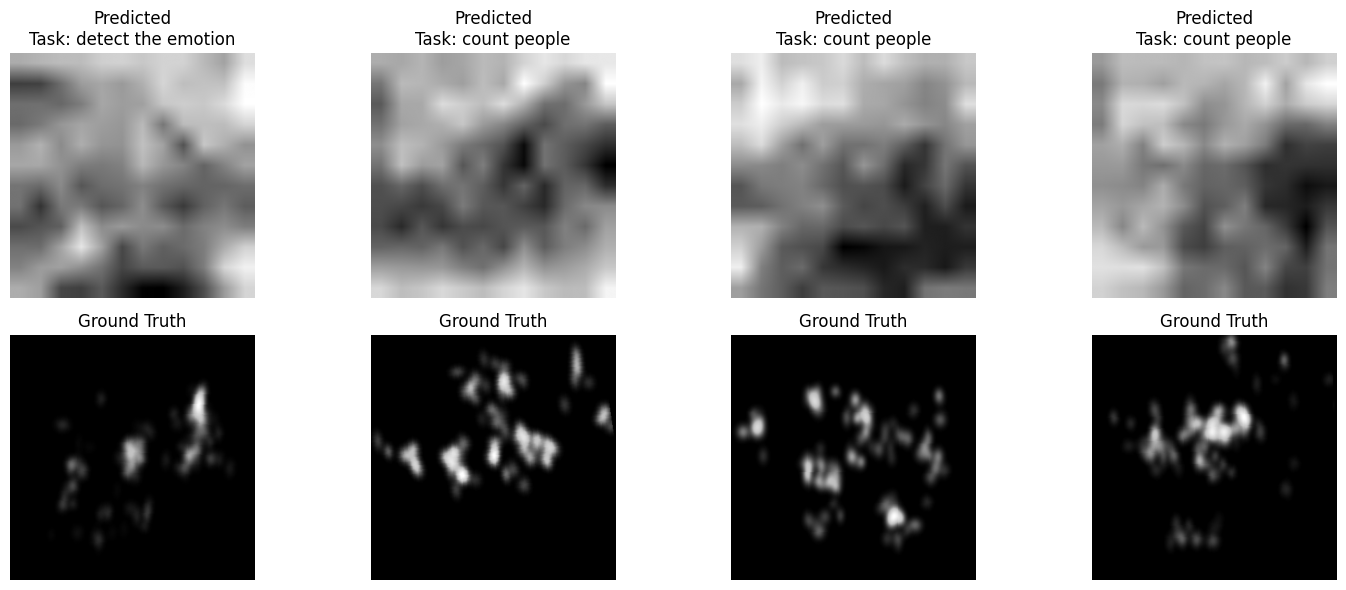

In [13]:
import torch
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model architecture (this should be exactly the same as during training)
model = YOLOTaskSaliencyModel().to(device)

# Load the saved state_dict from Drive
saved_model_path = "/content/drive/MyDrive/TDSP/yolo_task_saliency_model.pth"
model.load_state_dict(torch.load(saved_model_path, map_location=device))
model.eval()  # Set model to evaluation mode

# Fetch one batch from your dataloader (ensure your dataloader applies the same transforms as training)
batch_data = next(iter(dataloader))
images = batch_data["stimuli"].to(device)    # [B, 3, H, W]
fdm = batch_data["fdm"].to(device)           # [B, 1, H, W]
task_descs = batch_data["task_description"]  # List of task strings

# Run inference
with torch.no_grad():
    pred_saliency = model(images, task_descs)  # [B, 1, H, W]

# Convert predictions and ground truth to NumPy arrays for visualization
pred_saliency_np = pred_saliency.cpu().numpy()
fdm_np = fdm.cpu().numpy()

# Create a plot: top row for predicted saliency maps, bottom row for ground truth maps, in grayscale
num_samples = pred_saliency_np.shape[0]
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

for i in range(num_samples):
    axes[0, i].imshow(pred_saliency_np[i, 0], cmap='gray')
    axes[0, i].set_title(f"Predicted\nTask: {task_descs[i]}")
    axes[0, i].axis('off')

    axes[1, i].imshow(fdm_np[i, 0], cmap='gray')
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


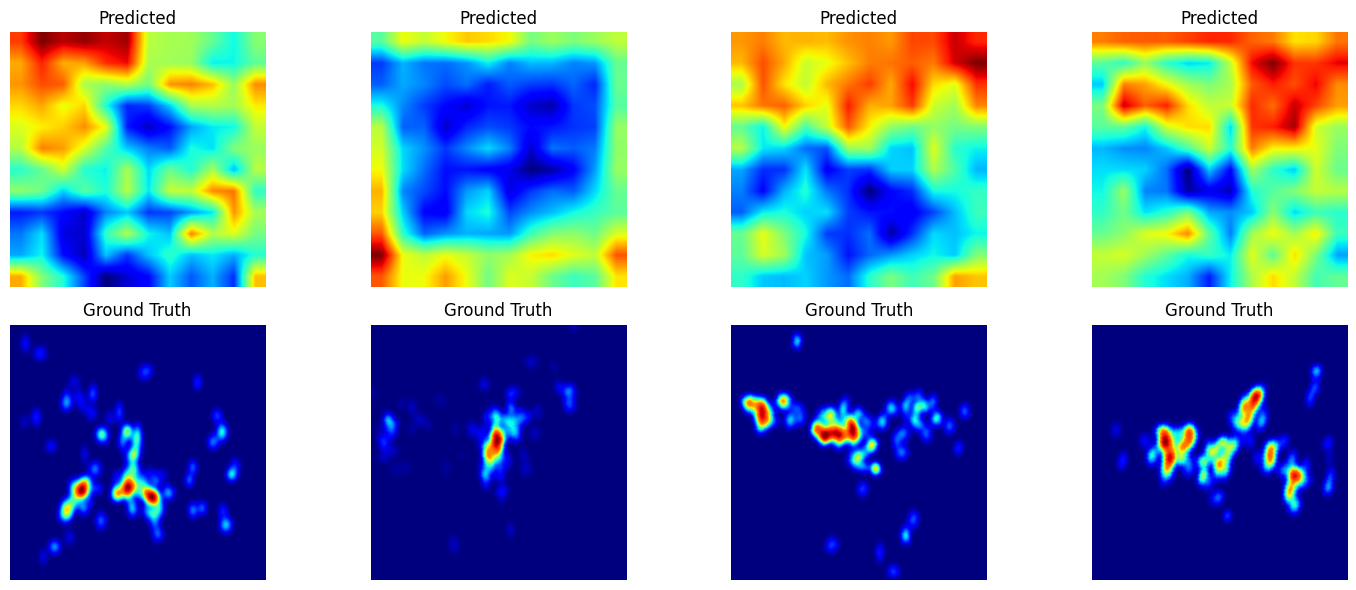

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    batch_data = next(iter(dataloader))
    images = batch_data["stimuli"].to(device)
    task_descs = batch_data["task_description"]
    pred_saliency = model(images, task_descs)

pred_saliency_np = pred_saliency.cpu().numpy()
fdm_np = batch_data["fdm"].cpu().numpy()

num_samples = pred_saliency_np.shape[0]
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
for i in range(num_samples):
    axes[0, i].imshow(pred_saliency_np[i, 0], cmap='jet')
    axes[0, i].set_title("Predicted")
    axes[0, i].axis('off')

    axes[1, i].imshow(fdm_np[i, 0], cmap='jet')
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

Evaluate model performance

In [ ]:
import torch

def correlation_coefficient(pred, gt):
    """
    Computes Pearson's Correlation Coefficient between two saliency maps.
    pred, gt: torch.Tensor of shape [H, W], assumed float in [0,1].
    Returns a scalar tensor (higher is better).
    """
    # Flatten to 1D
    pred_flat = pred.view(-1)
    gt_flat = gt.view(-1)

    pred_mean = pred_flat.mean()
    gt_mean = gt_flat.mean()

    numerator = ((pred_flat - pred_mean) * (gt_flat - gt_mean)).sum()
    denominator = torch.sqrt(((pred_flat - pred_mean)**2).sum() * ((gt_flat - gt_mean)**2).sum()) + 1e-12

    return numerator / denominator

def kl_divergence(pred, gt):
    """
    Computes KL Divergence between two saliency maps treated as probability distributions.
    pred, gt: torch.Tensor of shape [H, W], assumed float in [0,1].
    Returns a scalar tensor (lower is better).
    """
    eps = 1e-12
    # Normalize so each sums to 1
    pred_norm = pred / (pred.sum() + eps)
    gt_norm = gt / (gt.sum() + eps)

    return (gt_norm * torch.log((gt_norm + eps) / (pred_norm + eps))).sum()


In [ ]:
def evaluate_saliency_model(model, dataloader, device):
    model.eval()
    cc_scores = []
    kld_scores = []

    with torch.no_grad():
        for batch_data in dataloader:
            images = batch_data["stimuli"].to(device)  # [B, 3, H, W]
            fdm = batch_data["fdm"].to(device)         # [B, 1, H, W]
            task_descs = batch_data["task_description"]

            # 1. Forward pass
            pred_saliency = model(images, task_descs)  # [B, 1, H, W]

            # 2. For each item in the batch
            for i in range(images.size(0)):
                pred_map = pred_saliency[i, 0]  # shape [H, W]
                gt_map = fdm[i, 0]             # shape [H, W]

                # 3. Compute metrics
                cc = correlation_coefficient(pred_map, gt_map)
                kld = kl_divergence(pred_map, gt_map)

                cc_scores.append(cc.item())
                kld_scores.append(kld.item())

    # 4. Compute averages
    avg_cc = sum(cc_scores) / len(cc_scores) if cc_scores else 0
    avg_kld = sum(kld_scores) / len(kld_scores) if kld_scores else 0

    print(f"Average CC: {avg_cc:.4f}")
    print(f"Average KLD: {avg_kld:.4f}")
    return avg_cc, avg_kld

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
avg_cc, avg_kld = evaluate_saliency_model(model, dataloader, device)
